<a href="https://colab.research.google.com/github/mrdbourke/zero-to-mastery-ml/blob/master/section-4-unstructured-data-projects/end-to-end-dog-vision-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Recommends 100-1000 images per label - https://cloud.google.com/vertex-ai/docs/beginner/beginners-guide

# TODO:

# Get data
  # Original dataset = http://vision.stanford.edu/aditya86/ImageNetDogs/
  # Also see here = https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset
  # Can show original dataset format + TensorFlow Datasets format
  # Show how these differ/interact
# Prepare data
# Inspect data
# Create datasets (turn images into Tensors, if they already aren't)
# Create a model to train (make a function for this)
# Create a callback (to do things during training)
# Train a model on a small subset of the data (transfer learning)
# Evaluate model on small subset of the data
# Save and load a model
# Train a model on full dataset (transfer learning)
# Evaluate a model on the full dataset
# Make predictions on custom images

In [1]:
import tensorflow_datasets as tfds

In [2]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [ ]:
# Download the dataset into train and test split
# ds_train, ds_test = tfds.load('stanford_dogs', split=['train', 'test'])

In [ ]:
# TODO:
# Turn the dataset into standard image classification dataset, show what it looks like
# Download images/labels/lists from - http://vision.stanford.edu/aditya86/ImageNetDogs/
  # Images
  # Annotation
  # lists
    # How to format Images + Annotation + lists -> standard image datasets

In [ ]:
# TK - can I get the labels from here?
# !ls /root/tensorflow_datasets/stanford_dogs/0.2.0

## TK - Download data directly from Stanford Dogs website

In [3]:
# TODO: could potentially use the following code:, see: https://www.tensorflow.org/tutorials/images/classification
# import pathlib

# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
# data_dir = pathlib.Path(data_dir).with_suffix('')

# -nc or --no-clobber = don't download files that already exist locally
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar

--2023-10-26 01:19:35--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  15.0MB/s    in 59s     

2023-10-26 01:20:34 (12.9 MB/s) - ‘images.tar’ saved [793579520/793579520]

--2023-10-26 01:20:34--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘annotation.tar’

annotation.tar      100%[===================>]  20.84M  6.72MB/s    in 4.8s    

2023-10-26 01:20:39 (4.31 MB/s) - ‘annotat

In [4]:
# Untar images, x = extract files from the zipped file, v = verbose, z = decompress files, f = tell tar which file to deal with
!tar -xvf images.tar
!tar -xvf annotation.tar
!tar -xvf lists.tar

Streaming output truncated to the last 5000 lines.
Annotation/n02108089-boxer/n02108089_1575
Annotation/n02108089-boxer/n02108089_1619
Annotation/n02108089-boxer/n02108089_1626
Annotation/n02108089-boxer/n02108089_1654
Annotation/n02108089-boxer/n02108089_1672
Annotation/n02108089-boxer/n02108089_1675
Annotation/n02108089-boxer/n02108089_1690
Annotation/n02108089-boxer/n02108089_1748
Annotation/n02108089-boxer/n02108089_1757
Annotation/n02108089-boxer/n02108089_1775
Annotation/n02108089-boxer/n02108089_1859
Annotation/n02108089-boxer/n02108089_1912
Annotation/n02108089-boxer/n02108089_1956
Annotation/n02108089-boxer/n02108089_200
Annotation/n02108089-boxer/n02108089_2007
Annotation/n02108089-boxer/n02108089_2056
Annotation/n02108089-boxer/n02108089_2106
Annotation/n02108089-boxer/n02108089_2355
Annotation/n02108089-boxer/n02108089_2360
Annotation/n02108089-boxer/n02108089_2367
Annotation/n02108089-boxer/n02108089_2432
Annotation/n02108089-boxer/n02108089_2482
Annotation/n02108089-boxer

TK - save these files to Google Drive so you can import them later if necessary?

In [5]:
# Open lists of train and test .mat
import scipy
train_list = scipy.io.loadmat("train_list.mat")
test_list = scipy.io.loadmat("test_list.mat")
full_file_list = scipy.io.loadmat("file_list.mat")
len(full_file_list["file_list"])
type(train_list)

dict

In [6]:
train_file_list = list([item[0][0] for item in train_list["file_list"]])
test_file_list = list([item[0][0] for item in test_list["file_list"]])

len(train_file_list), len(test_file_list)

(12000, 8580)

In [7]:
# How many files in the training set intersect with the testing set?
# (should be 0)
set(train_file_list).intersection(test_file_list)

set()

In [8]:
# How many differences are there between train and test sets?
len(set(train_file_list).difference(test_file_list))

12000

In [9]:
# Total number of data points:
# Number of categories: 120
# Number of images: 20,580
12000+8580

20580

In [10]:
# Can move these to images/train/dog_name/img1.jpeg
# As well as images/test/dog_name/img2.jpeg
import random
random.sample(train_file_list, k=20)

['n02106030-collie/n02106030_14677.jpg',
 'n02086910-papillon/n02086910_3117.jpg',
 'n02090379-redbone/n02090379_1348.jpg',
 'n02093428-American_Staffordshire_terrier/n02093428_9513.jpg',
 'n02116738-African_hunting_dog/n02116738_10476.jpg',
 'n02101006-Gordon_setter/n02101006_1208.jpg',
 'n02091635-otterhound/n02091635_3703.jpg',
 'n02113712-miniature_poodle/n02113712_2150.jpg',
 'n02111889-Samoyed/n02111889_16676.jpg',
 'n02091032-Italian_greyhound/n02091032_8411.jpg',
 'n02097298-Scotch_terrier/n02097298_6740.jpg',
 'n02102973-Irish_water_spaniel/n02102973_1066.jpg',
 'n02097474-Tibetan_terrier/n02097474_8674.jpg',
 'n02099601-golden_retriever/n02099601_9504.jpg',
 'n02088364-beagle/n02088364_16060.jpg',
 'n02106662-German_shepherd/n02106662_23196.jpg',
 'n02105251-briard/n02105251_4802.jpg',
 'n02110958-pug/n02110958_13364.jpg',
 'n02093428-American_Staffordshire_terrier/n02093428_5146.jpg',
 'n02113023-Pembroke/n02113023_724.jpg']

In [11]:
from pathlib import Path

def count_subfolders(directory_path):
    return len([name for name in Path(directory_path).iterdir() if name.is_dir()])

directory_path = 'Annotation'
folder_count = count_subfolders(directory_path)
print(f'There are {folder_count} folders in {directory_path}')


There are 120 folders in Annotation


In [12]:
train_file_list_unique_class_names = list(set([item.split("/")[0] for item in train_file_list]))
len(train_file_list_unique_class_names)

120

In [13]:
dog_names_dict = {}
for item in sorted(train_file_list_unique_class_names):
  dog_names_dict[item] = len(item.split("/")[0].split("-"))

for key, value in dog_names_dict.items():
  if value > 2:
    print(key, value)

n02086240-Shih-Tzu 3
n02089078-black-and-tan_coonhound 4
n02095314-wire-haired_fox_terrier 3
n02098105-soft-coated_wheaten_terrier 3
n02099267-flat-coated_retriever 3
n02099429-curly-coated_retriever 3
n02100236-German_short-haired_pointer 3


In [14]:
# Get dog names
dog_names = sorted(list(set(["_".join(item.split("/")[0].split("-")[1:]).lower() for item in train_file_list])))
assert len(dog_names) == 120

In [15]:
dog_names

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black_and_tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly_coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat_coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short_haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [16]:
"_".join("n02099429-curly-coated_retriever".split("-")[1:])

'curly_coated_retriever'

In [17]:
len(dog_names)

120

In [18]:
# Create folder name -> class name dict
folder_to_class_name_dict = {}
for item in train_file_list_unique_class_names:
  folder_name = item
  # Turn folder name into class_name
  # E.g. "n02089078-black-and-tan_coonhound" -> "black_and_tan_coonhound"
  class_name = "_".join(item.split("-")[1:]).lower()
  folder_to_class_name_dict[folder_name] = class_name

len(folder_to_class_name_dict)

120

In [19]:
folder_to_class_name_dict

{'n02109047-Great_Dane': 'great_dane',
 'n02093859-Kerry_blue_terrier': 'kerry_blue_terrier',
 'n02093647-Bedlington_terrier': 'bedlington_terrier',
 'n02090622-borzoi': 'borzoi',
 'n02089078-black-and-tan_coonhound': 'black_and_tan_coonhound',
 'n02097047-miniature_schnauzer': 'miniature_schnauzer',
 'n02091244-Ibizan_hound': 'ibizan_hound',
 'n02085936-Maltese_dog': 'maltese_dog',
 'n02088094-Afghan_hound': 'afghan_hound',
 'n02102177-Welsh_springer_spaniel': 'welsh_springer_spaniel',
 'n02095570-Lakeland_terrier': 'lakeland_terrier',
 'n02089973-English_foxhound': 'english_foxhound',
 'n02096294-Australian_terrier': 'australian_terrier',
 'n02105056-groenendael': 'groenendael',
 'n02090721-Irish_wolfhound': 'irish_wolfhound',
 'n02101006-Gordon_setter': 'gordon_setter',
 'n02111500-Great_Pyrenees': 'great_pyrenees',
 'n02088632-bluetick': 'bluetick',
 'n02088364-beagle': 'beagle',
 'n02112137-chow': 'chow',
 'n02110806-basenji': 'basenji',
 'n02109525-Saint_Bernard': 'saint_bernard'

## TK - Explore data

TK - get a count of examples per class, e.g. Beagle: 165 etc

UPTOHERE
- How many images are in each class? ✅
- Can we use subsample of this to train a model? For example, only 10% of images ✅
- Train a transfer learning model on 10% of images from each class
  - Evaluate
- Train a transfer learning model on 100% of images from each class
  - Evaluate + calculate metrics
- Make a prediction on a set of custom images
  - Evaluate

In [20]:
# Create a dictionary of image counts
from pathlib import Path

def count_images_in_subdirs(directory: str):
  images_dir = Path(directory)
  image_class_dirs = [directory for directory in images_dir.iterdir() if directory.is_dir()]
  image_class_counts = []

  # Create a list of dictionaries to count number of images per dog breed (want these to be quite similar)
  for image_class_dir in image_class_dirs:
    folder_name = image_class_dir.stem
    image_count = len(list(image_class_dir.rglob("*.jpg"))) # get all files with .jpg file extension
    image_class_counts.append({"class_name": folder_name,
                               "image_count": image_count})

  return image_class_counts

image_class_counts = count_images_in_subdirs("Images")

# Create a DataFrame
import pandas as pd
image_counts_df = pd.DataFrame(image_class_counts).sort_values("image_count", ascending=False)
image_counts_df["class_name"] = image_counts_df["class_name"].map(folder_to_class_name_dict)
image_counts_df

class_name  image_count
38            maltese_dog          252
86           afghan_hound          239
15     scottish_deerhound          232
65             pomeranian          219
45   bernese_mountain_dog          218
..                    ...          ...
8                doberman          150
31               malinois          150
13                 kuvasz          150
115              pekinese          149
4                 redbone          148

[120 rows x 2 columns]

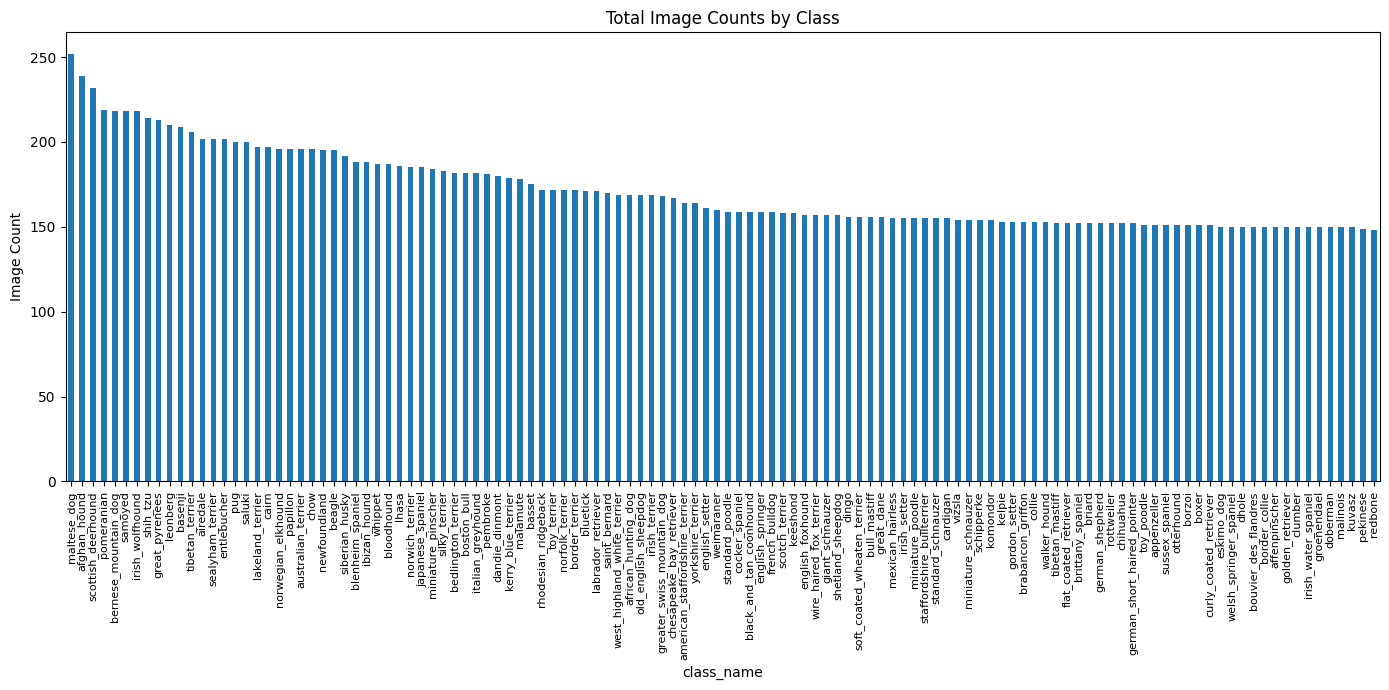

In [21]:
# TK - turn the DataFrame above into a graph
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
image_counts_df.plot(kind="bar",
                     x="class_name",
                     y="image_count",
                     legend=False,
                     ax=plt.gca()) # plt.gca() = "get current axis", get the plt we setup above and put the data there

# Add customization
plt.ylabel("Image Count")
plt.title("Total Image Counts by Class")
plt.xticks(rotation=90, # Rotate the x labels for better visibility
           fontsize=8) # Make the font size smaller for easier reading
plt.tight_layout() # Ensure things fit nicely
plt.show()

## TK - Create data splits

Want a directory structure of:

```
images_split/
  train/
    class_1/
    class_2/
    class_3/
  test/
    class_1/
    class_2/
    class_3/
```

In [22]:
from pathlib import Path

images_dir = "Images"
images_split_dir = Path("images_split")

train_dir = images_split_dir / "train"
test_dir = images_split_dir / "test"

# Using Path.mkdir with exist_ok=True ensures the directory is created only if it doesn't exist
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)
print(f"Directory {train_dir} is ensured to exist.")
print(f"Directory {test_dir} is ensured to exist.")

# Make a folder for each dog name
for dog_name in dog_names:
  # Make training dir folder
  train_class_dir = train_dir / dog_name
  train_class_dir.mkdir(parents=True, exist_ok=True)
  print(f"Making directory: {train_class_dir}")

  # Make testing dir folder
  test_class_dir = test_dir / dog_name
  test_class_dir.mkdir(parents=True, exist_ok=True)
  print(f"Making directory: {test_class_dir}")

# Make sure there is 120 subfolders in each
assert count_subfolders(train_dir) == len(dog_names)
assert count_subfolders(test_dir) == len(dog_names)

Directory images_split/train is ensured to exist.
Directory images_split/test is ensured to exist.
Making directory: images_split/train/affenpinscher
Making directory: images_split/test/affenpinscher
Making directory: images_split/train/afghan_hound
Making directory: images_split/test/afghan_hound
Making directory: images_split/train/african_hunting_dog
Making directory: images_split/test/african_hunting_dog
Making directory: images_split/train/airedale
Making directory: images_split/test/airedale
Making directory: images_split/train/american_staffordshire_terrier
Making directory: images_split/test/american_staffordshire_terrier
Making directory: images_split/train/appenzeller
Making directory: images_split/test/appenzeller
Making directory: images_split/train/australian_terrier
Making directory: images_split/test/australian_terrier
Making directory: images_split/train/basenji
Making directory: images_split/test/basenji
Making directory: images_split/train/basset
Making directory: ima

In [23]:
# Copy target images into their respective folders
from tqdm.auto import tqdm
from shutil import copy2

def copy_files_to_target_dir(file_list,
                             target_dir):
  for file in tqdm(file_list):
    source_file_path = Path(images_dir) / file

    file_class_name = folder_to_class_name_dict[file.split("/")[0]]
    file_image_name = file.split("/")[-1]

    destination_file_path = Path(target_dir) / file_class_name / file_image_name

    print(f"Copying: {source_file_path} to {destination_file_path}")
    copy2(src=source_file_path,
          dst=destination_file_path)

copy_files_to_target_dir(file_list=train_file_list,
                         target_dir=train_dir)

  0%|          | 0/12000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Copying: Images/n02102973-Irish_water_spaniel/n02102973_2442.jpg to images_split/train/irish_water_spaniel/n02102973_2442.jpg
Copying: Images/n02102973-Irish_water_spaniel/n02102973_4794.jpg to images_split/train/irish_water_spaniel/n02102973_4794.jpg
Copying: Images/n02102973-Irish_water_spaniel/n02102973_220.jpg to images_split/train/irish_water_spaniel/n02102973_220.jpg
Copying: Images/n02102973-Irish_water_spaniel/n02102973_3978.jpg to images_split/train/irish_water_spaniel/n02102973_3978.jpg
Copying: Images/n02102973-Irish_water_spaniel/n02102973_634.jpg to images_split/train/irish_water_spaniel/n02102973_634.jpg
Copying: Images/n02102973-Irish_water_spaniel/n02102973_4304.jpg to images_split/train/irish_water_spaniel/n02102973_4304.jpg
Copying: Images/n02102973-Irish_water_spaniel/n02102973_3344.jpg to images_split/train/irish_water_spaniel/n02102973_3344.jpg
Copying: Images/n02102973-Irish_water_spaniel/n02102973_1140.jpg to ima

In [24]:
copy_files_to_target_dir(file_list=test_file_list,
                         target_dir=test_dir)

# for file in tqdm(test_file_list):
#   source_file_path = Path(images_dir) / file

#   file_class_name = folder_to_class_name_dict[file.split("/")[0]]
#   file_image_name = file.split("/")[-1]

#   destination_file_path = Path(test_dir) / file_class_name / file_image_name

#   print(f"Copying: {source_file_path} to {destination_file_path}")
#   copy2(src=source_file_path,
#         dst=destination_file_path)

  0%|          | 0/8580 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Copying: Images/n02096437-Dandie_Dinmont/n02096437_3982.jpg to images_split/test/dandie_dinmont/n02096437_3982.jpg
Copying: Images/n02096437-Dandie_Dinmont/n02096437_3731.jpg to images_split/test/dandie_dinmont/n02096437_3731.jpg
Copying: Images/n02096437-Dandie_Dinmont/n02096437_1790.jpg to images_split/test/dandie_dinmont/n02096437_1790.jpg
Copying: Images/n02096437-Dandie_Dinmont/n02096437_1656.jpg to images_split/test/dandie_dinmont/n02096437_1656.jpg
Copying: Images/n02096437-Dandie_Dinmont/n02096437_91.jpg to images_split/test/dandie_dinmont/n02096437_91.jpg
Copying: Images/n02096437-Dandie_Dinmont/n02096437_2070.jpg to images_split/test/dandie_dinmont/n02096437_2070.jpg
Copying: Images/n02096437-Dandie_Dinmont/n02096437_4131.jpg to images_split/test/dandie_dinmont/n02096437_4131.jpg
Copying: Images/n02096437-Dandie_Dinmont/n02096437_1521.jpg to images_split/test/dandie_dinmont/n02096437_1521.jpg
Copying: Images/n02096437-Dandie_

In [25]:
# Get lengths of all paths of train and test images
train_image_paths = list(train_dir.rglob("*.jpg"))
test_image_paths = list(test_dir.rglob("*.jpg"))
assert len(train_image_paths) == len(train_file_list)
assert len(test_image_paths) == len(test_file_list)

len(train_image_paths), len(test_image_paths)

(12000, 8580)

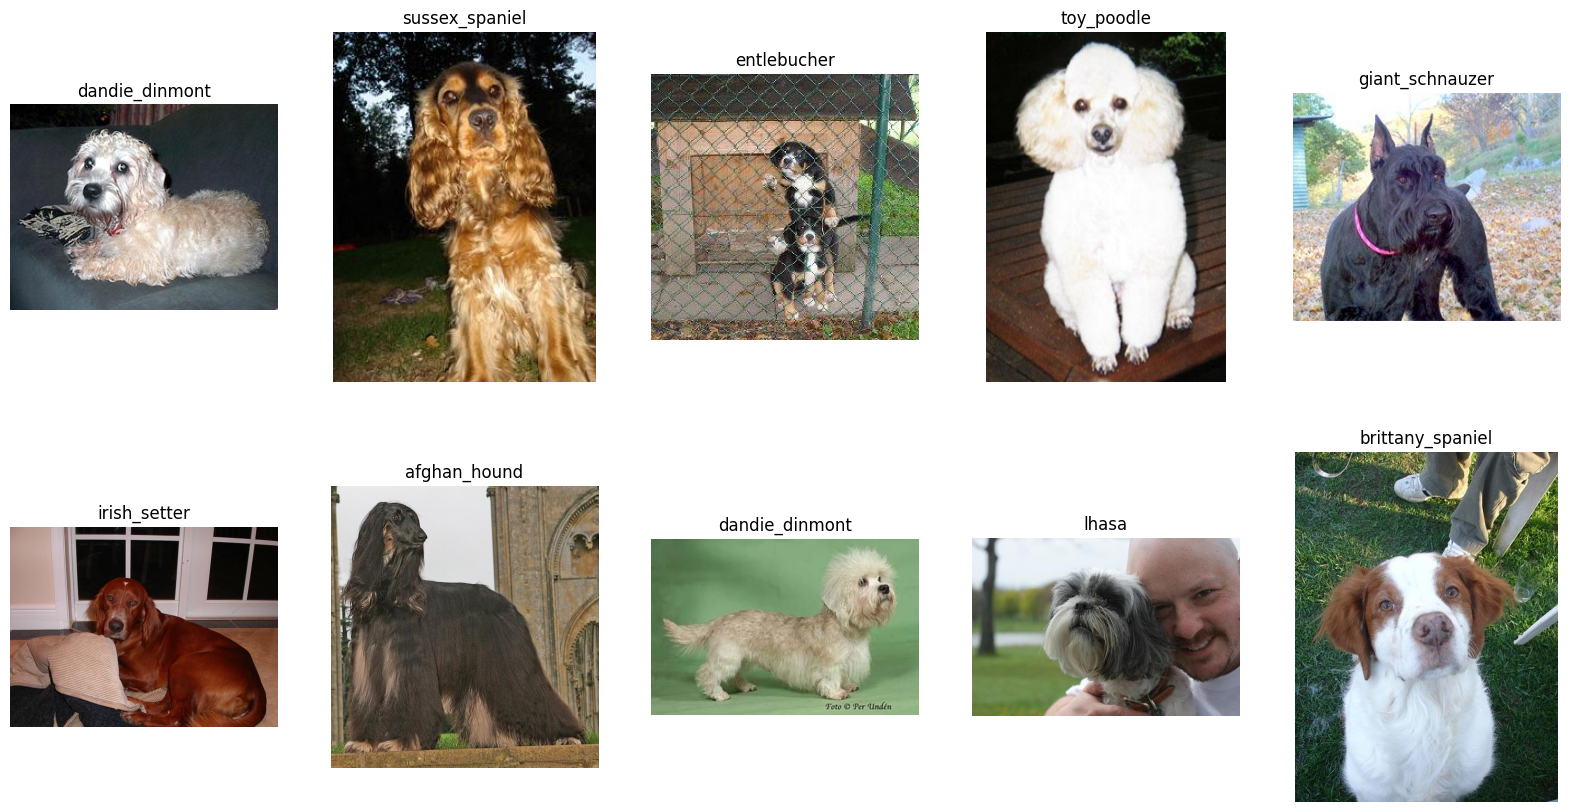

In [26]:
# Plot 10 random images from train_image_paths
import matplotlib.pyplot as plt

def plot_10_random_images_from_path_list(path_list: list):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    samples = random.sample(path_list, 10)
    for i, ax in enumerate(axes.flatten()):
        sample_path = samples[i]
        sample_title = sample_path.parent.stem
        ax.imshow(plt.imread(sample_path))
        ax.set_title(sample_title)
        ax.axis("off")

plot_10_random_images_from_path_list(train_image_paths)

### TK - Make a 10% training dataset

* Can copy a random 10% of the training images into a new folder
* Try to train a model on a smaller amount of data

In [27]:
# TK - get the train file paths
# Get a random 10% of them
# Copy them to a target directory, e.g. train_dir_10_percent

# Create train_10_percent directory
train_10_percent_dir = images_split_dir / "train_10_percent"
train_10_percent_dir.mkdir(parents=True, exist_ok=True)

import random
random.seed(42)

train_image_paths_random_10_percent = random.sample(population=train_image_paths,
                                                    k=int(0.1*len(train_image_paths)))
len(train_image_paths_random_10_percent)

for path in tqdm(train_image_paths_random_10_percent):
  source_file_path = path
  destination_file_path = train_10_percent_dir / Path(*path.parts[-2:])

  print(destination_file_path.parent)
  # If the target directory doesn't exist, make it
  target_class_dir = destination_file_path.parent
  if not target_class_dir.is_dir():
    print(f"Making directory: {target_class_dir}")
    target_class_dir.mkdir(parents=True,
                           exist_ok=True)

  print(f"Copying: {source_file_path} to {destination_file_path}")
  copy2(src=source_file_path,
        dst=destination_file_path)

  0%|          | 0/1200 [00:00<?, ?it/s]

images_split/train_10_percent/siberian_husky
Making directory: images_split/train_10_percent/siberian_husky
Copying: images_split/train/siberian_husky/n02110185_9194.jpg to images_split/train_10_percent/siberian_husky/n02110185_9194.jpg
images_split/train_10_percent/norwich_terrier
Making directory: images_split/train_10_percent/norwich_terrier
Copying: images_split/train/norwich_terrier/n02094258_2841.jpg to images_split/train_10_percent/norwich_terrier/n02094258_2841.jpg
images_split/train_10_percent/kuvasz
Making directory: images_split/train_10_percent/kuvasz
Copying: images_split/train/kuvasz/n02104029_1268.jpg to images_split/train_10_percent/kuvasz/n02104029_1268.jpg
images_split/train_10_percent/saint_bernard
Making directory: images_split/train_10_percent/saint_bernard
Copying: images_split/train/saint_bernard/n02109525_18948.jpg to images_split/train_10_percent/saint_bernard/n02109525_18948.jpg
images_split/train_10_percent/soft_coated_wheaten_terrier
Making directory: images

In [28]:
# Count images in train_10_percent_dir
train_10_percent_image_class_counts = count_images_in_subdirs(train_10_percent_dir)
train_10_percent_image_class_counts_df = pd.DataFrame(train_10_percent_image_class_counts).sort_values("image_count", ascending=True)
train_10_percent_image_class_counts_df

class_name  image_count
33                    border_collie            3
23                            lhasa            4
61                  standard_poodle            4
64                           kelpie            4
100                     groenendael            5
..                              ...          ...
40      soft_coated_wheaten_terrier           16
88                          whippet           16
11                         shih_tzu           17
43   american_staffordshire_terrier           18
90                      appenzeller           19

[120 rows x 2 columns]

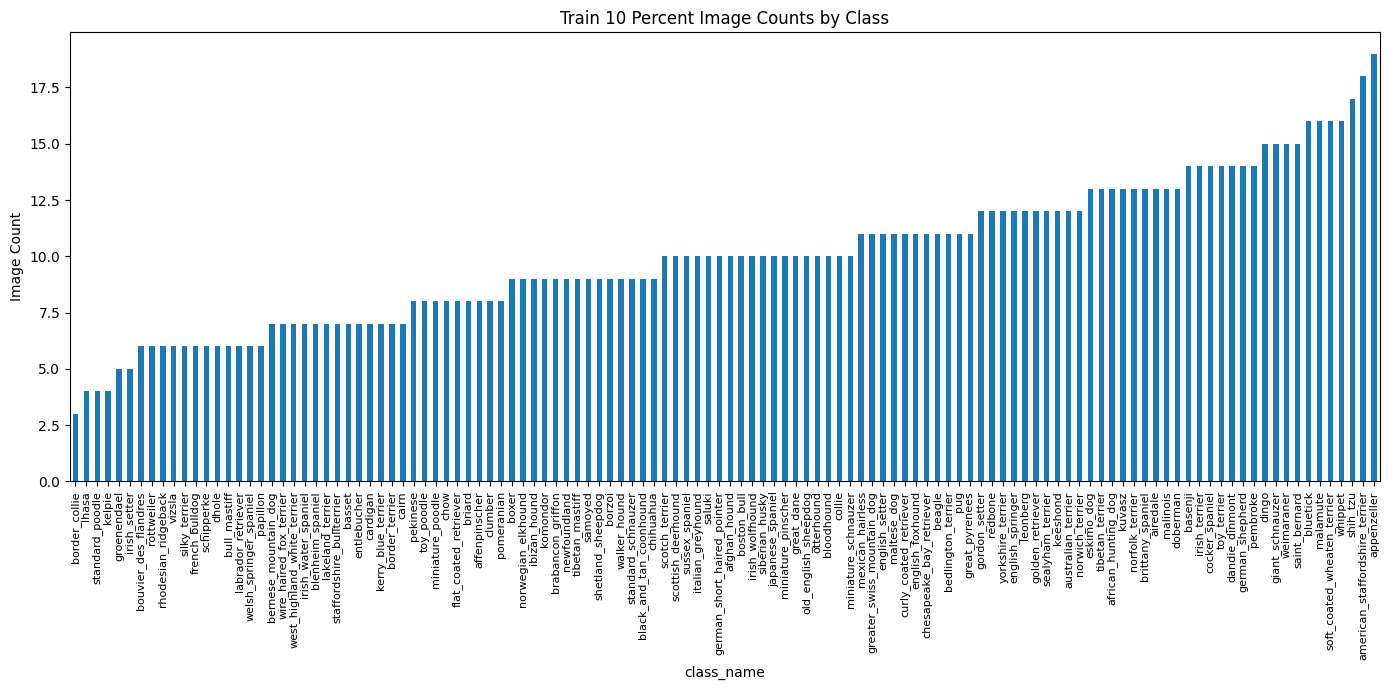

In [29]:
# TK - turn the DataFrame above into a graph
plt.figure(figsize=(14, 7))
train_10_percent_image_class_counts_df.plot(kind="bar",
                     x="class_name",
                     y="image_count",
                     legend=False,
                     ax=plt.gca()) # plt.gca() = "get current axis", get the plt we setup above and put the data there

# Add customization
plt.title("Train 10 Percent Image Counts by Class")
plt.ylabel("Image Count")
plt.xticks(rotation=90, # Rotate the x labels for better visibility
           fontsize=8) # Make the font size smaller for easier reading
plt.tight_layout() # Ensure things fit nicely
plt.show()

## TK - Turn datasets into TensorFlow Dataset(s)

* See here: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
* Also here: https://www.tensorflow.org/tutorials/load_data/images


> **Note:** TK - If you're working with similar styles of data (e.g. all dog photos), it's best practice to shuffle training datasets to prevent the model from learning any order in the data, no need to shuffle testing datasets (this makes for easier evaluation).

In [30]:
import tensorflow as tf

img_size = 224
batch_size = 32

train_10_percent_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_10_percent_dir,
    batch_size=32,
    image_size=(img_size, img_size),
    shuffle=True,
    seed=42
)

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    batch_size=32,
    image_size=(img_size, img_size),
    shuffle=True,
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    batch_size=32,
    image_size=(img_size, img_size),
    shuffle=False,
    seed=42
)

Found 1200 files belonging to 120 classes.
Found 12000 files belonging to 120 classes.
Found 8580 files belonging to 120 classes.


In [31]:
assert set(train_10_percent_ds.class_names) == set(train_ds.class_names) == set(test_ds.class_names)

In [32]:
class_names = train_ds.class_names
class_names[:5]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier']

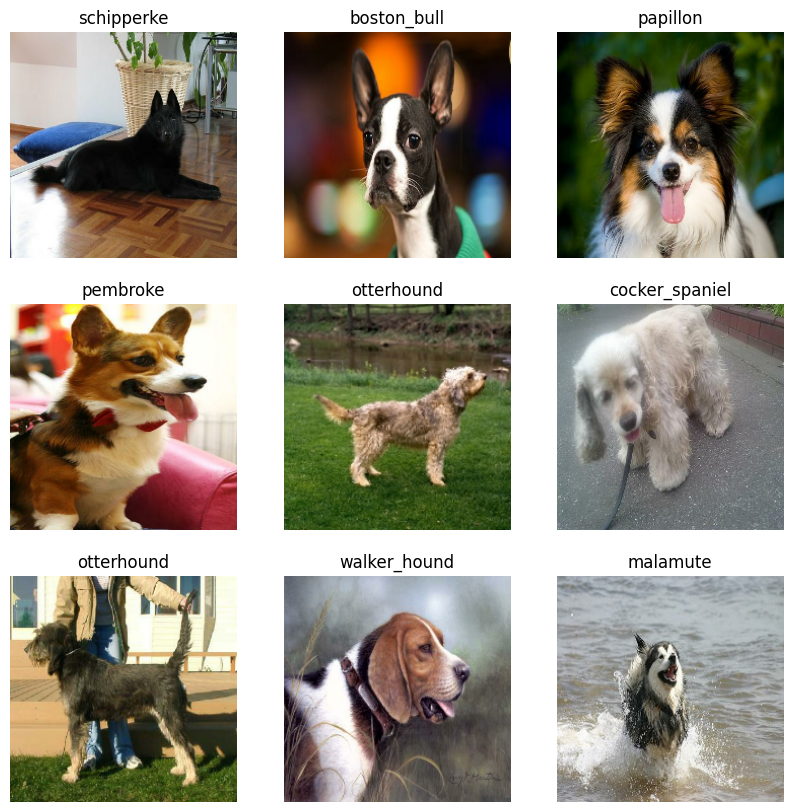

In [33]:
import matplotlib.pyplot as plt

# TK - change this to a similar version of the above plotting function
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [34]:
# TK - what does a single image look like?
image_batch, label_batch = next(iter(train_ds))
image_batch.shape, label_batch.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32]))

In [35]:
image_batch[0], label_batch[0], class_names[label_batch[0]]

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[ 95.33705 , 149.33705 , 213.33705 ],
         [ 95.33705 , 149.33705 , 213.33705 ],
         [ 95.33705 , 149.33705 , 213.33705 ],
         ...,
         [102.33705 , 154.33705 , 214.33705 ],
         [102.33705 , 152.33705 , 213.33705 ],
         [102.33705 , 152.33705 , 213.33705 ]],
 
        [[ 96.      , 150.      , 214.      ],
         [ 96.      , 150.      , 214.      ],
         [ 96.      , 150.      , 214.      ],
         ...,
         [103.      , 155.      , 215.      ],
         [103.      , 153.      , 214.      ],
         [103.      , 153.      , 214.      ]],
 
        [[ 96.685265, 150.68527 , 214.68527 ],
         [ 96.685265, 150.68527 , 214.68527 ],
         [ 96.685265, 150.68527 , 214.68527 ],
         ...,
         [103.685265, 155.68527 , 215.68527 ],
         [103.685265, 153.68527 , 214.68527 ],
         [103.685265, 153.68527 , 214.68527 ]],
 
        ...,
 
        [[ 98.23341 , 113.76687 

### TK - Configure the dataset for performance

* See here: https://www.tensorflow.org/guide/data_performance

In [36]:
AUTOTUNE = tf.data.AUTOTUNE

# Shuffle training datasets but don't need to shuffle test datasets (for easier evaluation)
train_10_percent_ds = train_10_percent_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## TK - Create model

### TK - Try transfer learning

* Only want to train the last layer of the model...
* See here: https://keras.io/guides/transfer_learning/

In [37]:
num_classes = len(class_names)

In [38]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=(img_size, img_size, 3),
    include_preprocessing=True
)

# base_model.summary()

# Freeze the base model
base_model.trainable = False
base_model.trainable

24274472/24274472 [==============================] - 1s 0us/step


False

In [39]:
# TK - functionize this model creation step

# Create new model
inputs = tf.keras.Input(shape=(224, 224, 3))

# TK - Create data augmentation
# x = data_augmentation(inputs)

# Craft model
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, name="output_layer")(x)
model_0 = tf.keras.Model(inputs, outputs, name="model_0")
model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 120)               153720    
                                                                 
Total params: 6073032 (23.17 MB)
Trainable params: 153720 (

In [53]:
# Functionize model creation
from typing import Tuple

def create_model(include_top: bool = False,
                 num_classes: int = 1000,
                 input_shape: Tuple[int, int, int] = (224, 224, 3),
                 include_preprocessing: bool = True,
                 trainable: bool = False,
                 dropout: float = 0.2,
                 model_name: str = "model") -> tf.keras.Model:
  """
  Create an EfficientNetV2 B0 feature extractor model with a custom classifier layer.

  Args:
      include_top (bool, optional): Whether to include the top (classifier) layers of the model.
      num_classes (int, optional): Number of output classes for the classifier layer.
      input_shape (Tuple[int, int, int], optional): Input shape for the model's images (height, width, channels).
      include_preprocessing (bool, optional): Whether to include preprocessing layers for image normalization.
      trainable (bool, optional): Whether to make the base model trainable.
      dropout (float, optional): Dropout rate for the global average pooling layer.
      model_name (str, optional): Name for the created model.

  Returns:
      tf.keras.Model: A TensorFlow Keras model with the specified configuration.
  """
  # Create base model
  base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=include_top,
    weights="imagenet",
    input_shape=input_shape,
    include_preprocessing=include_preprocessing
  )

  # Freeze the base model (if necessary)
  base_model.trainable = trainable

  # Create input layer
  inputs = tf.keras.Input(shape=input_shape, name="input_layer")

  # Create model backbone
  x = base_model(inputs, training=trainable)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)

  # Create output layer (also known as "classifier" layer)
  outputs = tf.keras.layers.Dense(num_classes, name="output_layer")(x)

  # Connect input and output layer
  model = tf.keras.Model(inputs,
                         outputs,
                         name=model_name)

  return model

model_0 = create_model(num_classes=len(class_names))
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_9 (Dropout)         (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 120)               153720    
                                                                 
Total params: 6073032 (23.17 MB)
Trainable params: 153720 (60

## TK - Model 0 - Train a model on 10% of the training data

A note on losses:
* If your labels are integers (e.g. `[[1], [23], [43], [16]...]`), use [`tf.keras.losses.SparseCategoricalCrossentropy()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)

In [49]:
model_0 = create_model(num_classes=len(class_names),
                       model_name="model_0")

model_0.compile(optimizer="adam", # or can use tf.keras.optimizers.Adam()
                # Set from_logits=True if the last layer of your net is a Dense layer
                #
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])

epochs=5
history_0 = model_0.fit(
  train_10_percent_ds,
  validation_data=test_ds,
  epochs=epochs
  # steps_per_epoch=0.1*len(train_ds) # TK - train with 10% of the data
)

Epoch 1/5
38/38 [==============================] - 17s 253ms/step - loss: 3.9195 - accuracy: 0.3058 - val_loss: 3.0065 - val_accuracy: 0.5526
Epoch 2/5
38/38 [==============================] - 7s 198ms/step - loss: 2.0087 - accuracy: 0.7817 - val_loss: 1.8462 - val_accuracy: 0.6817
Epoch 3/5
38/38 [==============================] - 7s 196ms/step - loss: 1.0382 - accuracy: 0.9117 - val_loss: 1.2790 - val_accuracy: 0.7591
Epoch 4/5
38/38 [==============================] - 7s 198ms/step - loss: 0.6081 - accuracy: 0.9542 - val_loss: 1.0119 - val_accuracy: 0.7914
Epoch 5/5
38/38 [==============================] - 7s 197ms/step - loss: 0.4061 - accuracy: 0.9725 - val_loss: 0.8775 - val_accuracy: 0.8054


In [51]:
# TK - functionize this model creation step
tf.keras.utils.set_random_seed(42)

# Create new model
inputs = tf.keras.Input(shape=(224, 224, 3))

# TK - Create data augmentation
# x = data_augmentation(inputs)

# Craft model
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, name="output_layer")(x)
model_0 = tf.keras.Model(inputs, outputs, name="model_0")
# model_0.summary()

model_0.compile(optimizer="adam",
                # Set from_logits=True if the last layer of your net is a Dense layer
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"],
                steps_per_execution="auto") # this requires TensorFlow v2.14.0+)

epochs=5
history_0 = model_0.fit(
  train_10_percent_ds,
  validation_data=test_ds,
  epochs=epochs,
  # steps_per_epoch=0.1*len(train_ds) # TK - train with 10% of the data
)

Epoch 1/5
38/38 [==============================] - 16s 252ms/step - loss: 3.9436 - accuracy: 0.2958 - val_loss: 3.0280 - val_accuracy: 0.5601
Epoch 2/5
38/38 [==============================] - 7s 199ms/step - loss: 2.0418 - accuracy: 0.7867 - val_loss: 1.8650 - val_accuracy: 0.6915
Epoch 3/5
38/38 [==============================] - 7s 199ms/step - loss: 1.0642 - accuracy: 0.9000 - val_loss: 1.2934 - val_accuracy: 0.7563
Epoch 4/5
38/38 [==============================] - 7s 199ms/step - loss: 0.6208 - accuracy: 0.9533 - val_loss: 1.0192 - val_accuracy: 0.7939
Epoch 5/5
38/38 [==============================] - 7s 200ms/step - loss: 0.4260 - accuracy: 0.9683 - val_loss: 0.8858 - val_accuracy: 0.8031


In [47]:
# Without dropout
# Epoch 1/5
# 38/38 [==============================] - 16s 238ms/step - loss: 3.9472 - accuracy: 0.3017 - val_loss: 3.0021 - val_accuracy: 0.5627
# Epoch 2/5
# 38/38 [==============================] - 7s 201ms/step - loss: 2.0007 - accuracy: 0.8158 - val_loss: 1.8314 - val_accuracy: 0.6969
# Epoch 3/5
# 38/38 [==============================] - 7s 201ms/step - loss: 1.0303 - accuracy: 0.9042 - val_loss: 1.2692 - val_accuracy: 0.7611
# Epoch 4/5
# 38/38 [==============================] - 7s 201ms/step - loss: 0.6037 - accuracy: 0.9542 - val_loss: 1.0139 - val_accuracy: 0.7880
# Epoch 5/5
# 38/38 [==============================] - 7s 201ms/step - loss: 0.4080 - accuracy: 0.9708 - val_loss: 0.8732 - val_accuracy: 0.8056

# With dropout
# Epoch 1/5
# 38/38 [==============================] - 17s 244ms/step - loss: 4.0580 - accuracy: 0.2425 - val_loss: 3.2023 - val_accuracy: 0.5360
# Epoch 2/5
# 38/38 [==============================] - 7s 195ms/step - loss: 2.2513 - accuracy: 0.7658 - val_loss: 2.0222 - val_accuracy: 0.6787
# Epoch 3/5
# 38/38 [==============================] - 7s 192ms/step - loss: 1.2264 - accuracy: 0.8850 - val_loss: 1.4008 - val_accuracy: 0.7462
# Epoch 4/5
# 38/38 [==============================] - 7s 195ms/step - loss: 0.7360 - accuracy: 0.9375 - val_loss: 1.0966 - val_accuracy: 0.7802
# Epoch 5/5
# 38/38 [==============================] - 7s 200ms/step - loss: 0.5009 - accuracy: 0.9608 - val_loss: 0.9299 - val_accuracy: 0.8052

### TK - Evaluate Model 0 on the test data

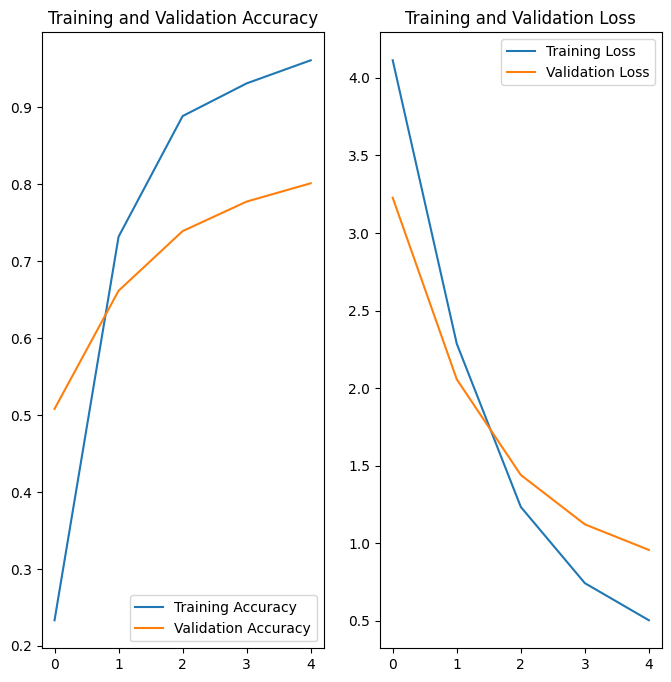

In [ ]:
# TK - functionize this

def plot_model_loss_curves(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

plot_model_loss_curves(history=history_0)

In [ ]:
# Evaluate model_0
model_0_results = model_0.evaluate(test_ds)

269/269 [==============================] - 6s 23ms/step - loss: 0.9571 - accuracy: 0.8010


[0.9571252465248108, 0.8010489344596863]

## TK - Model 1 - Train a model on 100% of the training data

UPTOHERE

Repeat the process for the above and compare the results

In [ ]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_preprocessing=True
)

# base_model.summary()

# Freeze the base model
base_model.trainable = False

# TK - functionize this

# Create new model
inputs = tf.keras.Input(shape=(224, 224, 3))

# TK - Create data augmentation
# x = data_augmentation(inputs)

# Craft model
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes,
                                name="output_layer",
                                activation="softmax")(x) # Note: If you have "softmax" activation, use from_logits=False in loss function
model_1 = tf.keras.Model(inputs, outputs, name="model_1")
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 120)               153720    
                                                                 
Total params: 6073032 (23.17 MB)
Trainable params: 153720 (

In [ ]:
# Compile the model
model_1.compile(optimizer="adam",
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # if no activation function at end of model, use "from_logits=True"
                metrics=["accuracy"])

# Train the model
tf.keras.utils.set_random_sed(42)
history_1 = model_1.fit(train_ds,
                        epochs=epochs,
                        validation_data=test_ds)

Epoch 1/5
375/375 [==============================] - 24s 45ms/step - loss: 1.3579 - accuracy: 0.7448 - val_loss: 0.5044 - val_accuracy: 0.8703
Epoch 2/5
375/375 [==============================] - 16s 42ms/step - loss: 0.3980 - accuracy: 0.8908 - val_loss: 0.4053 - val_accuracy: 0.8823
Epoch 3/5
375/375 [==============================] - 15s 41ms/step - loss: 0.2912 - accuracy: 0.9197 - val_loss: 0.3924 - val_accuracy: 0.8740
Epoch 4/5
375/375 [==============================] - 15s 41ms/step - loss: 0.2295 - accuracy: 0.9379 - val_loss: 0.3731 - val_accuracy: 0.8801
Epoch 5/5
375/375 [==============================] - 15s 41ms/step - loss: 0.1885 - accuracy: 0.9515 - val_loss: 0.3666 - val_accuracy: 0.8805


### TK - Evaluate Model 1 on the test data

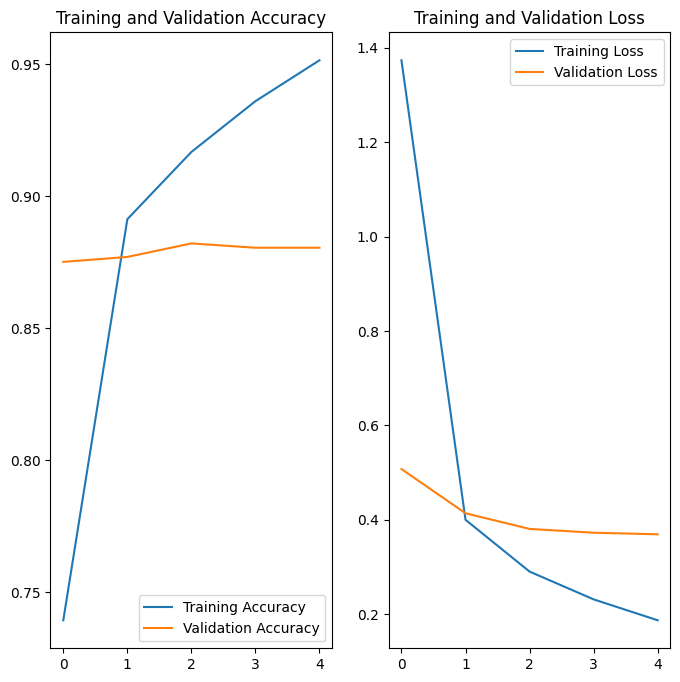

In [ ]:
plot_model_loss_curves(history=history_1)

In [ ]:
# Evaluate model_1
model_1_results = model_1.evaluate(test_ds)

269/269 [==============================] - 6s 24ms/step - loss: 0.3695 - accuracy: 0.8805


TK - looks like our model is overfitting...

### TK - Try data augmentation

See: https://www.tensorflow.org/tutorials/images/data_augmentation

In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation"
)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_preprocessing=True
)

# base_model.summary()

# Freeze the base model
base_model.trainable = False

# TK - functionize this

# Create new model
inputs = tf.keras.Input(shape=(224, 224, 3))

# TK - Create data augmentation
x = data_augmentation(inputs)

# Craft model
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes,
                                name="output_layer",
                                activation="softmax")(x) # Note: If you have "softmax" activation, use from_logits=False in loss function
model_2 = tf.keras.Model(inputs, outputs, name="model_2")
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                           

In [ ]:
# Compile the model
model_2.compile(optimizer="adam",
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # if no activation function at end of model, use "from_logits=True"
                metrics=["accuracy"])

# Train the model
history_2 = model_2.fit(train_ds,
                        epochs=epochs,
                        validation_data=test_ds)

Epoch 1/5
375/375 [==============================] - 25s 45ms/step - loss: 2.0019 - accuracy: 0.5707 - val_loss: 0.6256 - val_accuracy: 0.8550
Epoch 2/5
375/375 [==============================] - 15s 40ms/step - loss: 0.9631 - accuracy: 0.7317 - val_loss: 0.4655 - val_accuracy: 0.8707
Epoch 3/5
375/375 [==============================] - 15s 40ms/step - loss: 0.8105 - accuracy: 0.7688 - val_loss: 0.4270 - val_accuracy: 0.8713
Epoch 4/5
375/375 [==============================] - 15s 40ms/step - loss: 0.7186 - accuracy: 0.7880 - val_loss: 0.4063 - val_accuracy: 0.8745
Epoch 5/5
375/375 [==============================] - 15s 41ms/step - loss: 0.6615 - accuracy: 0.8046 - val_loss: 0.4029 - val_accuracy: 0.8711


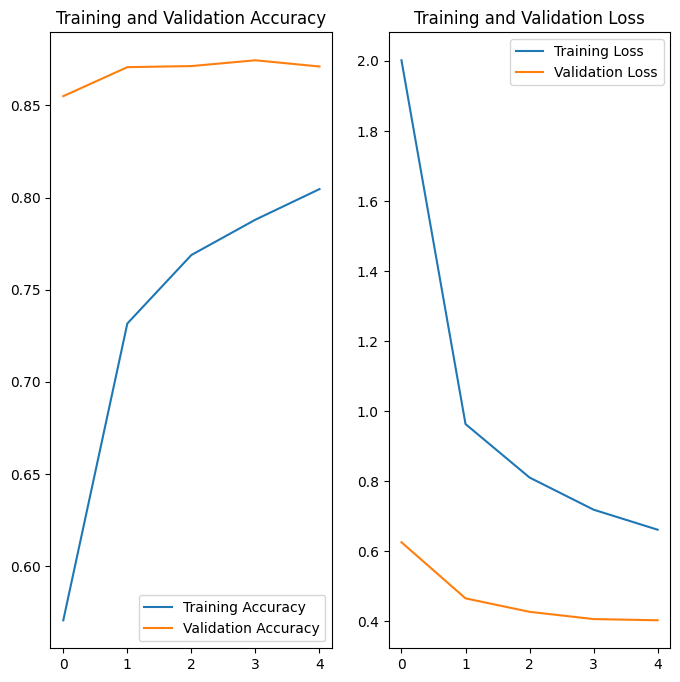

In [ ]:
plot_model_loss_curves(history=history_2)

UPTOHERE:

* Include callbacks?
* Go through notebook and fix sections that need fixing
* Add information to sections which should have information

## TK - Make and evaluate predictions of the best model

In [ ]:
# This will output logits (as long as softmax activation isn't in the model)
test_preds = model_1.predict(test_ds)

269/269 [==============================] - 6s 21ms/step


In [ ]:
# This will output prediction probabilities (easier to understand)
test_preds = tf.keras.activations.softmax(tf.constant(test_preds), axis=-1)

In [ ]:
test_preds.shape

TensorShape([8580, 120])

In [ ]:
test_preds[0].shape, tf.argmax(test_preds[0])

(TensorShape([120]), <tf.Tensor: shape=(), dtype=int64, numpy=0>)

In [ ]:
test_ds_images = np.concatenate([images for images, labels in test_ds], axis=0)
test_ds_labels = np.concatenate([labels for images, labels in test_ds], axis=0)
test_ds_labels[0], test_ds_images[0]

(0,
 array([[[ 43.804947,  44.804947,  38.804947],
         [ 39.12483 ,  40.12483 ,  34.12483 ],
         [ 82.701065,  83.701065,  77.62723 ],
         ...,
         [ 21.578135,  25.578135,  24.578135],
         [ 19.741274,  23.741274,  22.741274],
         [ 15.660867,  19.660868,  18.660868]],
 
        [[ 40.762886,  41.762886,  35.41467 ],
         [ 38.87469 ,  39.87469 ,  33.526478],
         [ 84.99161 ,  85.99161 ,  78.59259 ],
         ...,
         [ 20.462063,  24.462063,  23.462063],
         [ 19.207607,  23.207607,  22.207607],
         [ 18.408989,  22.408989,  21.408989]],
 
        [[ 37.69817 ,  38.69817 ,  30.698172],
         [ 42.096752,  43.096752,  35.096752],
         [ 93.62746 ,  94.81206 ,  86.258255],
         ...,
         [ 19.530594,  23.530594,  22.530594],
         [ 18.091536,  22.091536,  21.091536],
         [ 19.202106,  23.202106,  22.202106]],
 
        ...,
 
        [[106.28673 ,  70.28673 ,  96.28673 ],
         [105.43164 ,  69.43164 ,  95

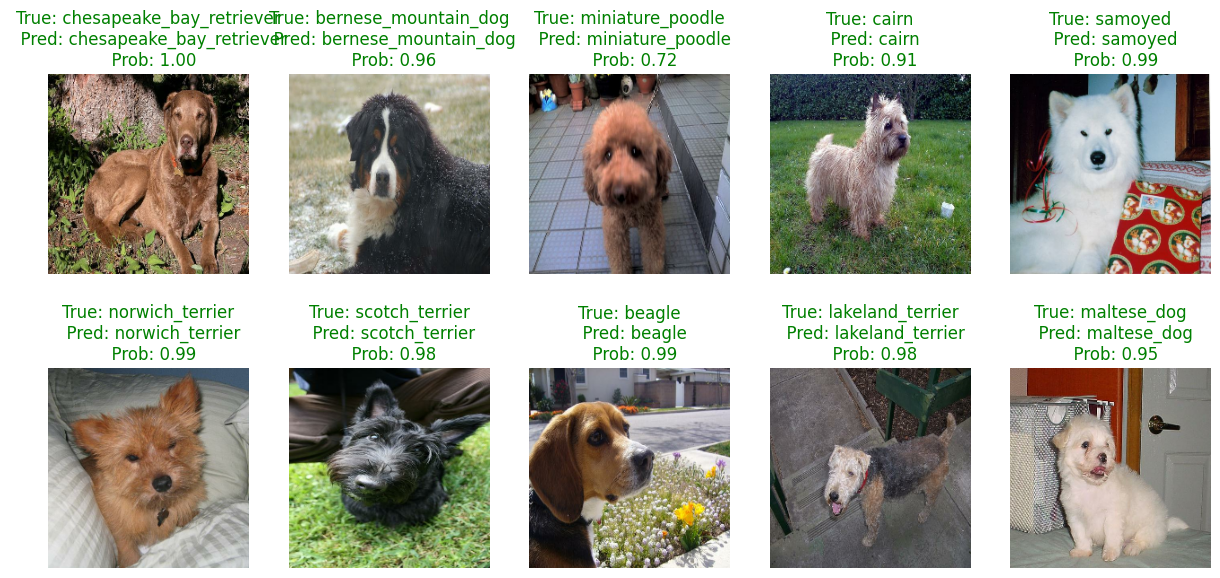

In [ ]:
# Choose a random 10 indexes from the test data and compare the values
import random

random_indexes = random.sample(range(len(test_ds_images)), 10)

# TK - this is why we don't shuffle the test data
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
for i, ax in enumerate(axes.flatten()):
  target_index = random_indexes[i]

  # Get relevant target image, label, prediction and prediction probabilities
  test_image = test_ds_images[target_index]
  test_image_truth_label = class_names[test_ds_labels[target_index]]
  test_image_pred_probs = test_preds[target_index]
  test_image_pred_class = class_names[tf.argmax(test_image_pred_probs)]

  # Plot the image
  ax.imshow(test_image.astype("uint8"))

  # Create sample title
  title = f"""True: {test_image_truth_label}
  Pred: {test_image_pred_class}
  Prob: {np.max(test_image_pred_probs):.2f}"""

  # Colour the title based on correctness of pred
  ax.set_title(title,
               color="green" if test_image_truth_label == test_image_pred_class else "red")
  ax.axis("off")

## TK - Save and load the best model

See here: https://www.tensorflow.org/tutorials/keras/save_and_load#new_high-level_keras_format

In [ ]:
# Save the model to .keras
model_1.save("dog_vision_model.keras")

In [ ]:
# Load the model
loaded_model = tf.keras.models.load_model("dog_vision_model.keras")

# Evaluate the loaded model
loaded_model_results = loaded_model.evaluate(test_ds)

269/269 [==============================] - 9s 24ms/step - loss: 0.3695 - accuracy: 0.8805


In [ ]:
assert model_1_results == loaded_model_results

## TK - Make predictions on custom images with the best model

In [ ]:
# TK - load custom image(s)
!wget -nc https://github.com/mrdbourke/zero-to-mastery-ml/raw/master/images/dog-photos.zip
!unzip dog-photos.zip

--2023-10-20 00:24:01--  https://github.com/mrdbourke/zero-to-mastery-ml/raw/master/images/dog-photos.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/zero-to-mastery-ml/master/images/dog-photos.zip [following]
--2023-10-20 00:24:01--  https://raw.githubusercontent.com/mrdbourke/zero-to-mastery-ml/master/images/dog-photos.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 961132 (939K) [application/zip]
Saving to: ‘dog-photos.zip’

dog-photos.zip      100%[===================>] 938.61K  --.-KB/s    in 0.02s   

2023-10-20 00:24:01 (44.8 MB/s) - ‘dog-photos.zip’ saved [961132/961132

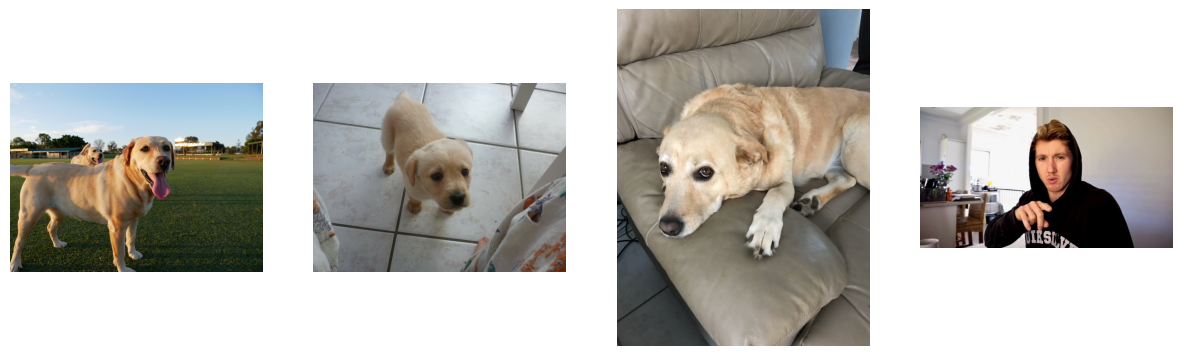

In [ ]:
# View images
custom_image_paths = ["dog-photo-1.jpeg",
                      "dog-photo-2.jpeg",
                      "dog-photo-3.jpeg",
                      "dog-photo-4.jpeg"]

fig, axes = plt.subplots(1, 4, figsize=(15, 7))
for i, ax in enumerate(axes.flatten()):
  ax.imshow(plt.imread(custom_image_paths[i]))
  ax.axis("off")

# def plot_10_random_images_from_path_list(path_list: list):
#     fig, axes = plt.subplots(2, 5, figsize=(20, 10))
#     samples = random.sample(path_list, 10)
#     for i, ax in enumerate(axes.flatten()):
#         sample_path = samples[i]
#         sample_title = sample_path.parent.stem
#         ax.imshow(plt.imread(sample_path))
#         ax.set_title(sample_title)
#         ax.axis("off")

In [ ]:
# This will error...
loaded_model.predict("dog-photo-1.jpeg")

IndexError: ignored

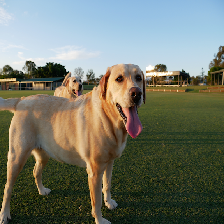

In [ ]:
# Model needs to make predictions on images in same format it was trained on


# Load the image
custom_image = tf.keras.utils.load_img(
  path="dog-photo-1.jpeg",
  color_mode="rgb",
  target_size=(img_size, img_size),
)

custom_image

In [ ]:
# Turn the image into a tensor
custom_image_tensor = tf.keras.utils.img_to_array(custom_image)
custom_image_tensor.shape

(224, 224, 3)

In [ ]:
loaded_model.predict(custom_image_tensor)

ValueError: ignored

In [ ]:
pred_probs = loaded_model.predict(tf.expand_dims(custom_image_tensor, axis=0))
pred_values = tf.keras.activations.softmax(tf.constant(pred_probs))
class_names[tf.argmax(pred_values, axis=-1).numpy()[0]]

1/1 [==============================] - 0s 43ms/step


In [ ]:
tf.expand_dims(custom_image_tensor, axis=0).shape

TensorShape([1, 224, 224, 3])

> **Note:** TK - In the case of some models you may need to rescale your values here, in our case the Rescaling layer is built-in to the model.


In [ ]:
def pred_on_custom_image(image_path,
                         model,
                         target_size=img_size,
                         class_names=class_names,
                         plot=True):

  # Prepare and load image
  custom_image = tf.keras.utils.load_img(
    path=image_path,
    color_mode="rgb",
    target_size=(target_size, target_size),
  )

  # Turn the image into a tensor
  custom_image_tensor = tf.keras.utils.img_to_array(custom_image)

  # Add a batch dimension to the target tensor (e.g. (224, 224, 3) -> (1, 224, 224, 3))
  custom_image_tensor = tf.expand_dims(custom_image_tensor, axis=0)

  # Make a prediction with the target model
  pred_probs = model.predict(custom_image_tensor)
  pred_values = tf.keras.activations.softmax(tf.constant(pred_probs))
  pred_class = class_names[tf.argmax(pred_values, axis=-1).numpy()[0]]

  # Plot if we want
  if not plot:
    return pred_class
  else:
    plt.figure(figsize=(5, 3))
    plt.imshow(plt.imread(image_path))
    plt.title(pred_class)
    plt.axis("off")

1/1 [==============================] - 0s 29ms/step


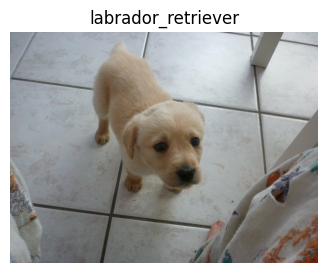

In [ ]:
pred_on_custom_image(image_path="dog-photo-2.jpeg", model=loaded_model)

1/1 [==============================] - 0s 28ms/step


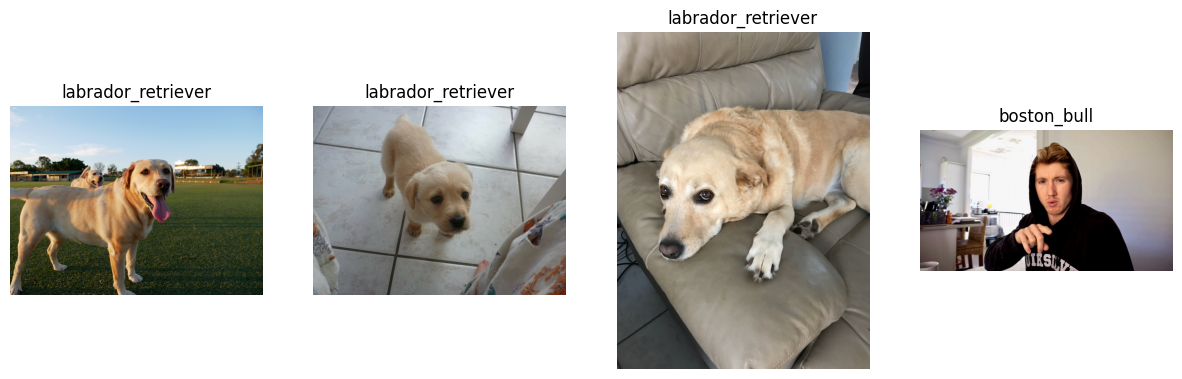

In [ ]:
# Predict on multiple images
fig, axes = plt.subplots(1, 4, figsize=(15, 7))
for i, ax in enumerate(axes.flatten()):
  image_path = custom_image_paths[i]
  pred_class = pred_on_custom_image(image_path=image_path,
                                    model=loaded_model,
                                    plot=False)
  ax.imshow(plt.imread(image_path))
  ax.set_title(pred_class)
  ax.axis("off")

## TK - Extensions & Exercises

* Try a prediction on your own images of dogs and see if the model is correct
* Train a model on your own custom set of image classes, for example, apple vs banana vs orange
* More callbacks -
* Data augmentation -
* Other models - see tf.keras.applications or Kaggle Models
* ZTM TensorFlow course -
  * See further fine-tuning here